# Deep Learning with keras

**Resources:** 
- [Keras Documentation](https://keras.io/)
- [Practical Deep Learning For Coders, Part 1](http://course.fast.ai/)

## Keras deep learning library installation on Windows

See: https://charmie11.wordpress.com/2016/05/09/keras-deep-learning-library-installation-on-windows/

## Working on the cloud with Amazon Web Services (AWS)

You can skip the hassle of setting up deep learning frameworks from scratch by choosing an Amazon Machine Image (AMI) that comes pre-installed with the libraries and their dependencies. It has in costs, but sometimes it worth it (you can use the spot request options for lower costs).

For example, the Stanford class, CS231n: Convolutional Neural Networksfor Visual Recognition, has provided a public AMI with these specs:

- cs231n_caffe_torch7_keras_lasagne_v2
- AMI ID: ami-125b2c72 in the us-west-1 region
- Use a g2.2xlarge instance.
- Caffe, Torch7, Theano, Keras and Lasagne are pre-installed. Python bindings of caffe are available. It has CUDA 7.5 and CuDNN v3.

If you’re new to AWS, CS231n provides a nice step-by-step [AWS tutorial](http://cs231n.github.io/aws-tutorial/).

[This tutorial](http://efavdb.com/deep-learning-with-jupyter-on-aws/) shows how to set up a public Jupyter notebook server in EC2 and then access it remotely through your web browser, just as you would if you were using a notebook launched from your own laptop.

In order to start the notebook server on an AWS instance, you should ssh into your instance. Since I didn't have a SSH client on my computer, I installed [PuTTY](http://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html) to connect to the Linux instance, but you can check the [OpenSSH project]( http://www.openssh.com) for other SSH tools.

Another useful thing when working on your AWS instance is the [Kaggle-CLI](http://wiki.fast.ai/index.php/Kaggle_CLI) command line tool that will let you download Kaggle data and submit entries from the command line. 

The two last things that I had to do to work on the given AMI were:
1. unzipping data:
    - sudo apt install unzip
    - unzip train.zip
2. upgrading keras:
    - pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

### Setups

Import numpy, theano and keras:

In [687]:
import numpy
import theano

In [688]:
import keras 
print(keras.__version__)

2.1.2


You can update a version by running :

In [86]:
#!pip install --upgrade keras

  Using cached Keras-2.1.2-py2.py3-none-any.whl
Requirement already up-to-date: numpy>=1.9.1 in c:\anaconda3\lib\site-packages (from keras)
Requirement already up-to-date: pyyaml in c:\anaconda3\lib\site-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in c:\anaconda3\lib\site-packages (from keras)
Requirement already up-to-date: scipy>=0.14 in c:\anaconda3\lib\site-packages (from keras)
  Found existing installation: Keras 1.2.0
    Uninstalling Keras-1.2.0:
      Successfully uninstalled Keras-1.2.0


I'll set an older version, in order to avoide updating other packages:

In [690]:
#!pip install keras==1.2

  Found existing installation: Keras 2.1.2
    Uninstalling Keras-2.1.2:
      Successfully uninstalled Keras-2.1.2


**note:** TensorFlow is also supported (as an alternative to Theano), but we stick with Theano to keep it simple. The main difference is that you'll need to reshape the data slightly differently before feeding it to your network.

In [691]:
from keras import backend as K
K.set_image_dim_ordering('th')

# Text Generation with Keras

Deep learning can be used for learning the sequences of a problem and then generating entirely new plausible sequences for the problem domain.
In order to demonstrate some new layers and models, let's try to train a model based on a given text and create a new text with similar sequential patterns.

## Loading Data

We're going to download the collected works of Nietzsche to use as our data for this class.

In [11]:
from keras.utils.data_utils import get_file
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read()
print('corpus length:', len(text))

corpus length: 600901


Let's first examine this data, and recognize some issues to handle:

In [12]:
text[0:2000]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been unskilled and unseemly methods for\nwinning a woman? Certainly she has never allowed herself to be won; and\nat present every kind of dogma stands with sad and discouraged mien--IF,\nindeed, it stands at all! For there are scoffers who maintain that it\nhas fallen, that all dogma lies on the ground--nay more, that it is at\nits last gasp. But to speak seriously, there are good grounds for hoping\nthat all dogmatizing in philosophy, whatever solemn, whatever conclusive\nand decided airs it has assumed, may have been only a noble puerilism\nand tyronism; and probably the time is at hand when it will be once\nand again understood WHAT has actually sufficed for the basis of such\

## Preprocessing the text to fit into a network

Most words in our text will only appear one or two times. 
It’s a good idea to remove these infrequent words. Having a huge vocabulary will make our model slow to train, and because we don’t have a lot of contextual examples for such words we wouldn’t be able to learn how to use them correctly anyway. 
That’s quite similar to how humans learn. To really understand how to appropriately use a word you need to have seen it in different contexts.
In our code we limit our vocabulary to the vocabulary_size most common words (which was set to 600, mainly for memory limitations). 

We replace all words not included in our vocabulary by UNKNOWN_TOKEN. 
For example, if we don’t include the word “nonlinearities” in our vocabulary:
    - “nonlineraties are important in neural networks” 
    - “UNKNOWN_TOKEN are important in Neural Networks”. 

In [13]:
vocabulary_size = 600
unknown_token = "UNKNOWNTOKEN"

We also want to learn which words tend start and end a sentence. 
To do this we prepend a special SENTENCE_START token, and append a special SENTENCE_END token to each sentence. 
This allows us to ask: 
Given that the first token is SENTENCE_START, what is the likely next word (the actual first word of the sentence)?

In [14]:
sentence_start_token = "SENTENCESTART"
sentence_end_token = "SENTENCEEND"

Notice that in Nietzsche's text, there seems to be some meaning to things like line breaks and seperators. In order for these patterns to be preserved, let's convert it to speciel tokens, otherwise it will be removed from the text with the rest of the punctuations.

In [15]:
line_break= "NEWLINE"
separator= "SEPARATOR"

Let's convert these special characters into the mentioned tokens:

In [16]:
text1 = text.replace('\n',' '+ line_break + ' ')
text1 = text1.replace('--',' '+ separator + ' ')
text1 = text1.replace('.',' '+sentence_end_token +' '+ sentence_start_token+' ' )
text1[0:2000]

'PREFACE NEWLINE  NEWLINE  NEWLINE SUPPOSING that Truth is a woman SEPARATOR what then? Is there not ground NEWLINE for suspecting that all philosophers, in so far as they have been NEWLINE dogmatists, have failed to understand women SEPARATOR that the terrible NEWLINE seriousness and clumsy importunity with which they have usually paid NEWLINE their addresses to Truth, have been unskilled and unseemly methods for NEWLINE winning a woman? Certainly she has never allowed herself to be won; and NEWLINE at present every kind of dogma stands with sad and discouraged mien SEPARATOR IF, NEWLINE indeed, it stands at all! For there are scoffers who maintain that it NEWLINE has fallen, that all dogma lies on the ground SEPARATOR nay more, that it is at NEWLINE its last gasp SENTENCEEND SENTENCESTART  But to speak seriously, there are good grounds for hoping NEWLINE that all dogmatizing in philosophy, whatever solemn, whatever conclusive NEWLINE and decided airs it has assumed, may have been onl

We have some text preprocessing functions in keras preprocessing.text module.
**text_to_word_sequence** splits a sentence into a list of words.
In this task we model the language as a sequence of words, so we use this function to split the entire text to a list of words, in its original order.
There are some parameters that allows to filter some unrelevant stuff and control the splitting:
- *filters:* list (or concatenation) of characters to filter out, such as punctuation. Default: base_filter(), includes basic punctuation, tabs, and newlines.
- *lower:* boolean. Whether to set the text to lowercase.
- *split:* str. Separator for word splitting.

In [17]:
from keras.preprocessing.text import text_to_word_sequence
text2 = text_to_word_sequence(text1, lower=False, split=" ") #using only 10000 first words

In [18]:
text2[0:10]

['PREFACE',
 'NEWLINE',
 'NEWLINE',
 'NEWLINE',
 'SUPPOSING',
 'that',
 'Truth',
 'is',
 'a',
 'woman']

The input to our Recurrent Neural Networks are vectors, not strings. So we create a mapping between words and indices. 

**Tokenizer** is a class for vectorizing texts, or/and turning texts into sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).
It considers the vocabulary size (nb_words) for indexing most frequent words, otherwise using the unknown-token index.

In [19]:
from keras.preprocessing.text import Tokenizer
token = Tokenizer(nb_words=600,char_level=False)
token.fit_on_texts(text2)

C:\Anaconda3\lib\site-packages\keras\preprocessing\text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


We represent each word as a one-hot vector of size vocabulary_size. 
For example, the word with index 36 would be the vector of all 0’s and a 1 at position 36. 
So, each word will become a vector, and the input will be a matrix, with each row representing a word. 

**texts_to_matrix** performs this conversion for us when setting the mode parameter to 'binary'.

In [20]:
text_mtx = token.texts_to_matrix(text2, mode='binary')

Our input is now a matrix. Each word has the size of the vocabulary:

In [21]:
text_mtx.shape

(118372, 600)

In [22]:
len(text2)

118372

In [23]:
import pandas as pd
import numpy as np
vocab = pd.DataFrame({'word':text2,'code':np.argmax(text_mtx,axis=1)})

In [24]:
vocab=vocab.drop_duplicates().sort('code')
vocab[:3]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,code,word
0,0,PREFACE
55824,0,THIRD
55827,0,indignantly


## Input & Output

Remember that our goal is to predict the next word, so output_ is just the input_ matrix shifted by one row 
It is that simple to do it:

In [25]:
input_ = text_mtx[:-1]
output_ = text_mtx[1:]

Making sure that they both have the same number of rows:

In [26]:
input_.shape, output_.shape

((118371, 600), (118371, 600))

## Create and train model

Importing the relevant modules:

In [84]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

Let's start by declaring a sequential model format, which is a linear stack of neural network layers. 

In [709]:
model = Sequential()

Next, we can simply add more layers to our model like we're building legos:

We start by adding an embedding layer, that turns positive integers (indexes) into dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

This layer can only be used as the first layer in a model.

In [710]:
model.add(Embedding(input_dim=input_.shape[1],output_dim= 42, input_length=input_.shape[1]))
# the model will take as input an integer matrix of size (batch, vocabulary_size).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, vocabulary_size, 42), where None is the batch dimension.

Let's connect it to a dense output layer, by first flattening the result, and then passing it to the output layer:

In [711]:
model.add(Flatten())
model.add(Dense(output_.shape[1], activation='sigmoid'))

For Dense layers, the first parameter is the output size of the layer. Keras automatically handles the connections between layers.
Note that the final layer has an output size of the vocabulary, corresponding to each index in the vocabulary.
Also note that the weights from the embedding layer must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

## Compile Model

We just need to compile the model and we'll be ready to train it. When we compile the model, we declare the loss function and the optimizer (sgd, Adam, etc.).

In [712]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

Keras has a variety of [loss functions](https://keras.io/objectives/)  and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from.

Because this is a multi-class classification problem, we can use the log loss function (called “categorical_crossentropy” in Keras), and optimize the network using the rmsprop optimization optimizer, which is is usually a good choice for recurrent neural networks. 

**categorical_crossentropy** is also known as multiclass logloss. Note: using this objective requires that your labels are binary arrays of shape (nb_samples, nb_classes).

The actual optimized loss is the mean of the output array across all datapoints.

## Train the Model

To fit the model, all we have to do is declare the batch size and number of epochs to train for, then pass in our training data.

We usually train for several hundreds of iterations (nb_epoch), but I'm out of time here, so you will mostly view in this session poor results that could be easily improved with longer training.

In [ ]:
model.fit(input_, y=output_, batch_size=200, nb_epoch=10, verbose=1, validation_split=0.2)

C:\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  max_q_size: maximum size for the generator queue


Train on 94696 samples, validate on 23675 samples
Epoch 1/10
  200/94696 [..............................] - ETA: 2:18 - loss: 4.8896 - acc: 0.0000e+00  400/94696 [..............................] - ETA: 2:15 - loss: 4.7185 - acc: 0.0000e+00  600/94696 [..............................] - ETA: 2:19 - loss: 4.7173 - acc: 0.0117      800/94696 [..............................] - ETA: 2:16 - loss: 4.6094 - acc: 0.0137 1000/94696 [..............................] - ETA: 2:15 - loss: 4.5261 - acc: 0.0130 1200/94696 [..............................] - ETA: 2:13 - loss: 4.45

## Check the Model

You can also use a variety of callbacks to set early-stopping rules, save model weights along the way, or log the history of each training epoch.

In [714]:
model.save_weights('weights_1')

In [715]:
model.load_weights('weights_1')

## Evaluate model on test data

Finally, we can evaluate our model on the test data:

In [716]:
score = model.evaluate(input_,output_, verbose=0)
score
#(loss,accuracy)

[3.3922732705569265, 0.14287283202836676]

To predict the class labels, we can then use the predict_classes method to return the class labels directly as integers:

In [717]:
y_test_pred = model.predict_classes(input_, verbose=0)

In [718]:
y_test_pred.shape

(118371,)

Comparing a sample of true and predicted labels:

In [719]:
import numpy as np
np.argmax(output_[:150:10],axis=1)

array([  1,  44,  21,   0,   1,   0,   0, 237,  60,  11,  23,  21,  13,
         5,  12], dtype=int64)

In [720]:
y_test_pred[:150:10]

array([4, 4, 1, 1, 4, 4, 1, 1, 1, 4, 9, 1, 1, 1, 1], dtype=int64)

Predicting probabilities for each class:

In [721]:
probs = model.predict_proba(input_, verbose=0)

In [722]:
probs[1]

array([5.41178250e-17, 1.03345021e-09, 3.17614102e-10, 3.77417181e-10,
       5.24395805e-10, 2.41877546e-10, 3.30501143e-12, 5.48998548e-17,
       1.56096108e-10, 8.58819751e-11, 8.86526200e-11, 2.30165691e-12,
       9.65985625e-11, 6.21548438e-11, 8.60205032e-11, 6.16482143e-11,
       5.33132254e-11, 1.27810757e-11, 1.71790152e-11, 5.61647534e-11,
       2.57353930e-11, 9.97394268e-12, 2.33259904e-11, 1.42741296e-11,
       1.57949591e-11, 2.02788463e-11, 1.77293735e-11, 2.54098669e-11,
       9.64293402e-12, 8.74314249e-12, 1.14051659e-11, 9.92386468e-12,
       9.79088425e-12, 1.60335686e-11, 9.15038791e-12, 1.24934594e-11,
       1.78804957e-11, 1.23501435e-11, 1.47317054e-11, 1.85107173e-11,
       1.37886751e-11, 8.45183645e-12, 1.66086988e-11, 1.21529687e-11,
       9.00764793e-12, 7.56969227e-12, 4.29442202e-12, 3.71187239e-12,
       4.33188598e-12, 6.65464298e-12, 5.66181867e-12, 2.69454576e-12,
       1.26949475e-11, 2.16301499e-12, 8.48096853e-12, 3.27938544e-12,
      

In [723]:
probs.shape

(118371, 600)

## Generating new text

Let's define a function that accepts a word, convert it to its one-hot representation, predicts the following word using the trained model, and finally convert the predicted one-hot result into a text and returns it.

In [724]:
def get_next(text,token,model,vocabulary):
    '''Predicts the following word, given a text word, a tokenizer to convert it to 1-hot vector, a trained model and a vocabulary
    with word and index representations'''
    #converting the word to 1-hot matrix represenation
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    #predicting next word
    bestMatch=model.predict_classes(tmp)[0]
    return vocabulary[vocabulary['code']==bestMatch]['word'].values[0]

We can now use this function, together with some saved parameters from the preprocessing phase, to predict the next word:

In [739]:
get_next("say",token,model,vocab)

'to'

In [741]:
get_next("did",token,model,vocab)

'not'

Let's try another model. This time we also use a RNN layer.

### Recurrent Neural Network

Let's use **SimpleRNN** to add a fully-connected RNN where the output is to be fed back to input.

In [742]:
from keras.layers.recurrent import SimpleRNN
n_hidden = 256
n_fac = 42
model=Sequential([
        Embedding(input_dim= input_.shape[1], output_dim= n_fac, input_length=input_.shape[1]),
        SimpleRNN(n_hidden, activation='relu', inner_init='identity'),
        Dense(output_.shape[1], activation='softmax')
    ])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(256, recurrent_initializer="identity", activation="relu")`


In [743]:
model.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
embedding_29 (Embedding)                     (None, 600, 42)                         25200          
____________________________________________________________________________________________________
simple_rnn_45 (SimpleRNN)                    (None, 256)                             76544          
____________________________________________________________________________________________________
dense_92 (Dense)                             (None, 600)                             154200         
Total params: 255,944
Trainable params: 255,944
Non-trainable params: 0
____________________________________________________________________________________________________


Let's compile the model and fit it to the data

In [745]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

In [ ]:
model.fit(input_, y=output_, batch_size=300, nb_epoch=5, verbose=1, validation_split=0.2)

C:\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  max_q_size: maximum size for the generator queue


Train on 94696 samples, validate on 23675 samples
Epoch 1/5
  300/94696 [..............................] - ETA: 12:11 - loss: 11.1382 - acc: 0.0000e+00  600/94696 [..............................] - ETA: 11:33 - loss: nan - acc: 0.1150          900/94696 [..............................] - ETA: 11:08 - loss: nan - acc: 0.1511 1200/94696 [..............................] - ETA: 10:53 - loss: nan - acc: 0.1742 1500/94696 [..............................] - ETA: 10:44 - loss: nan - acc: 0.1927 1800/94696 [..............................] - ETA: 10:35 - loss: nan - acc: 0.1961

## Task 2 - Recurrent Neural Network

1. Load the bible.txt file, store its first 10,000 characters (to get quicker answers) and check its length. 
2. Preprocess the text with keras Tokenizer. This time we want to train a model that generates text character-by-character instead of word-by-word as we did before. 
    - notice the char_level parameter and set it properly
    - set the dictionary size to contain 100 most frequent characters 
    - convert characters to lower to free entries in your dictionary
    - train tokenizer on the text
3. Convert the tokenized data (a sequence of characters) into a binary matrix form. 
4. Set the input and output matrices
5. Create a model with:
    - an Embedding input layer with 42 entries
    - a SimpleRNN layer with 186 hidden nodes and a relu activation function and identity initialization
    - a Dense output layer with a softmax activation function
6. Compile the model with the rmsprop optimizer and fit it to the data for three epochs.

# Back to nietzsche's data

Let's go back to nietzsche's data, but this time we will train models to understand the sequence of characters, instead the sequence of characters.

In [5]:
from keras.utils.data_utils import get_file
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read()
print('corpus length:', len(text))

corpus length: 600901


First we check to see the number of unique characters in the text. These characters will be our vocabulay.

In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 86


Here is our vocabulary:

In [7]:
''.join(chars[1:-6]) #the last six are unreadable

' !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz'

Map from chars to indices and back again

In [8]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

*idx* will be the data we use from now own - it simply converts all the characters to their index (based on the mapping above)

In [9]:
idx = [char_indices[c] for c in text]
idx[:10]

[39, 41, 28, 29, 24, 26, 28, 0, 0, 0]

To get text instead of the stored indices in idx, we use the indices_char conversion array that we calculated earlier:

In [10]:
''.join(indices_char[i] for i in idx[:70])

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

## 3 char model

### Create inputs

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters.
Let's use range to generate values in the range given by three parameters: start, stop, and step

In [191]:
cs=3
c1_dat = [idx[i] for i in range(0, len(idx)-1-cs, cs)]
c2_dat = [idx[i+1] for i in range(0, len(idx)-1-cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx)-1-cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx)-1-cs, cs)]

Our inputs: (let's just convert these list into arrays)

In [192]:
import numpy as np
x1 = np.array(c1_dat)
x2 = np.array(c2_dat)
x3 = np.array(c3_dat)
x1.shape,x2.shape,x3.shape

((200299,), (200299,), (200299,))

Putting it all in one matrix:

In [193]:
xs = np.stack([x1,x2,x3],axis=1)
xs.shape

(200299, 3)

Our output

In [194]:
y = np.array(c4_dat)
y.shape

(200299,)

The first 4 inputs and outputs

In [195]:
xs[:4]

array([[39, 41, 28],
       [29, 24, 26],
       [28,  0,  0],
       [ 0, 42, 44]])

In [196]:
y[:4]

array([29, 28,  0, 39])

### Create and train model

Create inputs and embedding outputs for each of our 3 character inputs.
We will use:
1. an Embedding layer, which turn positive integers (indexes) into dense vectors of fixed size
2. SimpleRNN layer, which is a fully-connected RNN where the output is to be fed back to input.
3. a dense output layer. Note that its size is set to the vocabulary size since it returns the probabilities for each possible target index.

The number of latent factors to create in the Enbedding Layer (i.e. the size of the embedding matrix)

In [197]:
n_fac = 42

This is the number of inputs:

In [198]:
cs=3

Here is the number of hidden nodes in the RNN layer:

In [199]:
n_hidden= 256

and this is the vocabulary size that we calculated before:

In [200]:
vocab_size

86

In [19]:

model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, activation='relu', inner_init='identity'),
        Dense(vocab_size, activation='softmax')
    ])

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 3, 42)         3612        embedding_input_1[0][0]          
____________________________________________________________________________________________________
simplernn_1 (SimpleRNN)          (None, 256)           76544       embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 86)            22102       simplernn_1[0][0]                
Total params: 102,258
Trainable params: 102,258
Non-trainable params: 0
____________________________________________________________________________________________________


Let's compile the model. This time we use the sparse_categorical_crossentropy loss that accepts sparse labels (index instead of hot-one representation). 

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Let's fit the model. 

In [ ]:
model.fit(xs, y, batch_size=200, nb_epoch=10)

Epoch 1/10
153600/200299 [======================>.......] - ETA: 2s - loss: 2.5177 - acc: 0.3035    400/200299 [..............................] - ETA: 25s - loss: 4.4164 - acc: 0.0825

Let's define a prediction function and use it to predict some characters and check the model:

In [23]:
def get_next_keras(inp):
    idxs = [char_indices[c] for c in inp] #convert characters to indices
    arrs = np.array(idxs)[np.newaxis,:] #converting to the required input format
    p = model.predict(arrs)[0] #using the model to predict the next index
    return chars[np.argmax(p)] #converting the index with max probability to a character

Notice that our get_next_keras is very basic, it always predicts the character with the highest probability. That means that for the same input we will always get the same prediction. It may be a good idea to change the prediction so that instead of choosing the character with maximum probability it will sample a character acording to the various distributions.

In [24]:
get_next_keras('thi')

'n'

In [25]:
get_next_keras('par')

't'

## Returning sequences

Let's now train a model that gets three characters and generates the next character for each of them.

First we need to change our output to contain three characters.

Here, c_out_dat is identical to c_in_dat, but moved across 1 character.

In [201]:
ys = xs[1:,:]
xs =  xs[:-1,:] # ignore the last character that has no known prediction

To convert our previous keras model into a sequence model, simply add the 'return_sequences=True' parameter, and add TimeDistributed() around our dense layer.

The TimeDistributed wrapper allows to apply a layer to every temporal slice of an input.

The dimension of index one will be considered to be the temporal dimension.

In [202]:
from keras.layers.wrappers import TimeDistributed 
model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, return_sequences=True, activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(256, return_sequences=True, recurrent_initializer="identity", activation="relu")`


In [205]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [216]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 3, 42)             3612      
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 3, 256)            76544     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 86)             22102     
Total params: 102,258
Trainable params: 102,258
Non-trainable params: 0
_________________________________________________________________


Some reshaping must be made in order to get the input and the output to the right format (adding a dimension to the output).

In [206]:
x_rnn=xs
y_rnn=np.expand_dims(ys, -1)
x_rnn.shape, y_rnn.shape

((200298, 3), (200298, 3, 1))

In [ ]:
model.fit(x_rnn, y_rnn, batch_size=64, nb_epoch=8)

C:\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/8
    64/200298 [..............................] - ETA: 1:38 - loss: 4.4564 - acc: 0.0104   576/200298 [..............................] - ETA: 31s - loss: 4.3943 - acc: 0.0747    960/200298 [..............................] - ETA: 29s - loss: 4.3114 - acc: 0.0934  1600/200298 [..............................] - ETA: 26s - loss: 4.1168 - acc: 0.1121  2240/200298 [..............................] - ETA: 24s - loss: 3.9837 - acc: 0.1223  2816/200298 [..............................] - ETA: 23s - loss: 3.8969 - acc: 0.1250

Checking the model is very similar to what we did before:

In [209]:
def get_nexts_keras(inp):
    idxs = [char_indices[c] for c in inp]
    arr = np.array(idxs)[np.newaxis,:]
    p = model.predict(arr)[0]
    print(list(inp)) #print the original input
    return [chars[np.argmax(o)] for o in p]

In [210]:
get_nexts_keras('don')

['d', 'o', 'n']


['e', ' ', 't']

Let's try again with cs=8:

In [256]:
cs=8
c_in_dat = [[idx[i+n] for i in range(0, len(idx)-1-cs, cs)]
            for n in range(cs)]
# c_out_dat is identical to c_in_dat, but moved across 1 character. 
c_out_dat = [[idx[i+n] for i in range(1, len(idx)-cs, cs)] 
            for n in range(cs)]
xs_8 = [np.stack(c[:-2]) for c in c_in_dat]
ys_8 = [np.stack(c[:-2]) for c in c_out_dat]
xs_8 = np.array(xs_8).T
ys_8 = np.array(ys_8).T


In [257]:
ys_8.shape

(75110, 8)

In [258]:
xs_8.shape

(75110, 8)

In [259]:
xs_8

array([[39, 41, 28, ..., 26, 28,  0],
       [ 0,  0, 42, ..., 39, 38, 42],
       [32, 37, 30, ..., 60, 53, 72],
       ...,
       [71, 72, 61, ...,  1, 75, 67],
       [70, 64, 56, ..., 71,  1, 72],
       [60, 57,  1, ..., 56, 61, 55]])

In [260]:
n_hidden, n_fac, cs, vocab_size = (256, 42, 8, 86)

In [261]:

model=Sequential([
        Embedding(vocab_size, n_fac, input_length=cs),
        SimpleRNN(n_hidden, return_sequences=True, activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(256, return_sequences=True, recurrent_initializer="identity", activation="relu")`


In [262]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 8, 42)             3612      
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 8, 256)            76544     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 8, 86)             22102     
Total params: 102,258
Trainable params: 102,258
Non-trainable params: 0
_________________________________________________________________


In [263]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [274]:
x_rnn=xs_8
y_rnn=np.expand_dims(ys_8, axis=2)
x_rnn.shape, y_rnn.shape

((75110, 8), (75110, 8, 1))

In [ ]:
model.fit(x_rnn, y_rnn, batch_size=64, nb_epoch=8)

C:\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/8
   64/75110 [..............................] - ETA: 20s - loss: 1.7412  320/75110 [..............................] - ETA: 16s - loss: 1.6732  576/75110 [..............................] - ETA: 16s - loss: 1.6829  768/75110 [..............................] - ETA: 17s - loss: 1.6873 1024/75110 [..............................] - ETA: 17s - loss: 1.7144 1280/75110 [..............................] - ETA: 16s - loss: 1.7103 1536/75110 [..............................] - ETA: 16s - loss: 1.7063 1728/7511

In [279]:
get_nexts_keras(' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


['t', 'h', 'e', 's', ' ', 'm', 's', ' ']

## Stateful RNN

Ideally, we want to expose the network to the entire sequence and let it learn the inter-dependencies, rather than us define those dependencies explicitly in the framing of the problem.
You can set RNN layers to be 'stateful', which means that the states computed for the samples in one batch will be reused as initial states for the samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches.

A stateful model is easy to create (just add "stateful=True") but harder to train. 

When using stateful in keras, you have to also add 'batch_input_shape' to the first layer, and fix the batch size there.

In [71]:
bs=200 # the batch size

In [72]:
from keras.layers.embeddings import Embedding
#from keras.layers.recurrent import LSTM
#from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import SimpleRNN
n_hidden = 256
n_fac = 42
model=Sequential([
        Embedding(input_dim= input_.shape[1], output_dim= n_fac, input_length=input_.shape[1],batch_input_shape=(bs,input_.shape[1])),
        SimpleRNN(n_hidden, activation='relu', stateful=True),
        Dense(output_.shape[1], activation='softmax')
    ])

In [73]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

Since we're using a fixed batch shape, we have to ensure our inputs and outputs are an even multiple of the batch size.

In [74]:
mx = len(input_)//bs*bs
mx # the number of records that actually divides with bs^2

118200

We now fit the model, without shuffling the records, so that it can learn from the original sequence of samples.

In [ ]:
model.fit(input_[:mx], output_[:mx].astype(float), batch_size=bs, nb_epoch=5,shuffle=False)

Epoch 1/5
118200/118200 [==============================] - 1109s - loss: nan - acc: 0.2235            

In [7]:
#Update to newer version and restart kernel in order for the following examples to work
#!pip install --upgrade keraspip install mkdocs


# Generative Adversarial Networks  (GANs)

These are models that can learn to create data that is similar to data that we give them. 

The main idea behind a GAN is to have two competing neural network models. One takes noise as input and generates samples (and so is called the generator). The other model (called the discriminator) receives samples from both the generator and the training data, and has to be able to distinguish between the two sources. These two networks play a continuous game, where the generator is learning to produce more and more realistic samples, and the discriminator is learning to get better and better at distinguishing generated data from real data. These two networks are trained simultaneously, and the hope is that the competition will drive the generated samples to be indistinguishable from real data. ( [An introduction to Generative Adversarial Networks](http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/))

In [428]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://blog.aylien.com/wp-content/uploads/2016/08/gan-768x432.png")

See this [link](https://www.youtube.com/watch?v=x0uWw8WLCVs) for a demonstration of a nice tool that is based on a GAN implementation.

Now let's train a GAN to generate Nietzsche's text, aided by some code examples: [KerasGAN](https://github.com/osh/KerasGAN/blob/master/MNIST_CNN_GAN.ipynb) and [keras-molecules](https://github.com/maxhodak/keras-molecules/blob/gan/SMILES_GAN.ipynb)

We first import all relevant modules:

In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
#from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten#,MaxoutDense
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import random, sys, keras
from keras.models import Model
from IPython import display
import keras 

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

from keras.callbacks import ReduceLROnPlateau
#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Activation,Concatenate
from keras.layers.recurrent import SimpleRNN,LSTM


ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
Using Theano backend.


We also define two help functions, the first will be used for describing the models improvement along the train process, the second will be used for freezing the discriminator's weights.

In [2]:
def plot_loss(losses):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='Discriminative loss')
    plt.plot(losses["g"], label='Generative loss')
    plt.legend()
    plt.show()

In [3]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

Let's set a many-to-many generator that accepts 3 charachters and predicts the following character for each.

idx is the representation of our text data with indices:

In [11]:
idx[:5]

[39, 41, 28, 29, 24]

Here we prepare the required input, this time in matrix (1-hot) representation:

In [13]:
cs=3
c1_dat = np.array([idx[i] for i in range(0, len(idx)-1-cs, 1)])
c2_dat = np.array([idx[i+1] for i in range(0, len(idx)-1-cs, 1)])
c3_dat = np.array([idx[i+2] for i in range(0, len(idx)-1-cs, 1)])
c4_dat = np.array([idx[i+3] for i in range(0, len(idx)-1-cs, 1)])
xs = np.stack([c1_dat,c2_dat,c3_dat],axis=1)
ys = np.stack([c2_dat,c3_dat,c4_dat],axis=1)

oh_ys = [to_categorical(o, vocab_size) for o in ys]
output__=np.stack(oh_ys, axis=0)

oh_xs = [to_categorical(o, vocab_size) for o in xs]
input__=np.stack(oh_xs, axis=0)

The new input/output structure is:

In [20]:
input__.shape, output__.shape

((600897, 3, 86), (600897, 3, 86))

And here we convert it from 1-hot representation back to indices:

In [21]:
input__.argmax(2)

array([[39, 41, 28],
       [41, 28, 29],
       [28, 29, 24],
       ...,
       [73, 64, 66],
       [64, 66, 57],
       [66, 57, 71]], dtype=int64)

In [22]:
output__.argmax(2)

array([[41, 28, 29],
       [28, 29, 24],
       [29, 24, 26],
       ...,
       [64, 66, 57],
       [66, 57, 71],
       [57, 71, 71]], dtype=int64)

We are ready to define the network. 

First we define a generator. Here we use a very similar model to the one we used before, this time the input is 1-hot instead of inices representation, so we ommited the embedding layer, and updfated the input_shape to be cs characters, each represented by a vector of size vocab_size.

In [44]:
#hidden_size = 64
batchSize=256
n_hidden=256
cs = 3
n_fac=42
vocab_size=86
#generator=Sequential([
#        SimpleRNN(n_hidden, return_sequences=True, input_shape=(cs, vocab_size),
#                  activation='relu'),
#        TimeDistributed(Dense(vocab_size, activation='softmax')),
#    ])

generator=Sequential([
        SimpleRNN(n_hidden, return_sequences=True, input_shape=(cs, vocab_size),
                  activation='relu', inner_init='identity'),
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])
generator.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(256, return_sequences=True, activation="relu", recurrent_initializer="identity", input_shape=(3, 86))`


In [45]:
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 3, 256)            87808     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 3, 86)             22102     
Total params: 109,910
Trainable params: 109,910
Non-trainable params: 0
_________________________________________________________________


After successfully compiling the generator, we define a discriminator that usees a similar RNN layer, but then outputs two possible outcomes (2 hidden nodes in the last layer): real or fake.

In [46]:
#discriminator=Sequential([
#        SimpleRNN(n_hidden,activation='relu',input_shape=(cs, vocab_size)),
#        Dense(2, activation='softmax')
#    ])
discriminator=Sequential([
        SimpleRNN(n_hidden, input_shape=(cs, vocab_size),
                  activation='relu'),
        Dense(2, activation='softmax'),
    ])
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam())
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (None, 256)               87808     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 514       
Total params: 88,322
Trainable params: 88,322
Non-trainable params: 0
_________________________________________________________________


Here we build the entire GAN model: The generator accepts the input (named gan_input) and its output is used as the input of the discriminator. 
We name the discriminator's output gan_V, and define a model that transfers gan_input to gan_V.

In [47]:
# Freeze weights in the discriminator for stacked training
make_trainable(discriminator, False)

# Build stacked GAN model
gan_input = Input(shape=[cs,vocab_size])

H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=Adam())
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, 86)             0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 3, 86)             109910    
_________________________________________________________________
sequential_14 (Sequential)   (None, 2)                 88322     
Total params: 198,232
Trainable params: 109,910
Non-trainable params: 88,322
_________________________________________________________________


We have about 600,000 input records, to make it faster for this class, let's use only a sample of size ntrain = 100000 

We define two input sets, and eventually concatenate it into a single input:
1. (XT,YT) are the real input\output texts samples (each input or output sample is a 3-gram)
2. (noise_gen,generated) are the randomly generated input samples and its generated output.

In [48]:
ntrain = 100000
trainidx = random.sample(range(0,input__.shape[0]), ntrain)
XT = input__[trainidx]
YT = output__[trainidx]

#noise_gen = np.random.choice(np.arange(vocab_size),size=[ntrain,cs])
noise_gen = np.zeros(XT.shape,dtype='float32')
for i in np.arange(XT.shape[0]):
     for t in np.arange(XT.shape[1]):
        p=np.random.choice(range(XT.shape[2]))
        noise_gen[i, t, p] = 1.
generated = generator.predict(noise_gen)


x = np.concatenate((generated,XT))
# set target: first half as fake and second half as real samples
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

In [49]:
x.shape,y.shape

((200000, 3, 86), (200000, 2))

Pretraining the generator...
We get lower accuracies, probably since we removed the embedding layer in this 1-hot input version.

In [50]:
def pretrain(n_pretrain = 10000, nb_epoch = 20, batch_size = 64):
    idx = np.random.randint(0,input__.shape[0],size=n_pretrain)
    text_batch = input__[idx] 
    text__output_batch = output__[idx] 
    noise_gen = np.zeros([n_pretrain,cs,vocab_size],dtype='float32')
    noise_output_gen = np.zeros([n_pretrain,cs,vocab_size],dtype='float32')
    for i in np.arange(n_pretrain):
         for t in np.arange(cs):
            p=np.random.choice(range(vocab_size))
            noise_gen[i, t, p] = 1.
            if t>0:
                noise_output_gen[i, t-1, p] = 1.
            else:
                noise_output_gen[i,cs-1,np.random.choice(range(vocab_size))]=1.
    #noise_gen = np.random.choice(np.arange(vocab_size),size=[n_pretrain,cs])
    #noise_gen = np.random.choice([0,1],size=(n_pretrain,input__.shape[1],input__.shape[2]))
    #noise_output_gen = np.random.choice([0,1],size=(n_pretrain,cs))#input__.shape[1],input__.shape[2]))
    #generated_texts = generator.predict([noise_gen,noise_gen])
    make_trainable(discriminator, False)
    #smiles_batch = data_train[np.random.choice(data_train.shape[0], size = n_pretrain)]
    #noise_gen = np.random.normal(0, 1, size=[n_pretrain, 100])
    generator.fit(
        noise_gen,
        noise_output_gen,
        nb_epoch = nb_epoch,
        batch_size = batch_size,
        callbacks = [
            ReduceLROnPlateau(monitor = 'loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.0001)])

In [ ]:
pretrain(n_pretrain=600000, nb_epoch=8)

C:\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/8
    64/600000 [..............................] - ETA: 4:51 - loss: 4.4638 - acc: 0.0208   512/600000 [..............................] - ETA: 1:35 - loss: 4.4592 - acc: 0.0150   896/600000 [..............................] - ETA: 1:27 - loss: 4.4592 - acc: 0.0123  1280/600000 [..............................] - ETA: 1:25 - loss: 4.4591 - acc: 0.0117  1728/600000 [..............................] - ETA: 1:21 - loss: 4.4592 - acc: 0.0118  2112/600000 [..............................] - ETA: 1:21 - loss: 4.4603 - acc: 0.0117

Pre-train the discriminator network ...

In [ ]:
make_trainable(discriminator,True)
discriminator.fit(x,y , epochs=2, batch_size=300)

Epoch 1/2
   300/200000 [..............................] - ETA: 15s - loss: 0.6538  1200/200000 [..............................] - ETA: 12s - loss: 0.5901  2100/200000 [..............................] - ETA: 12s - loss: 0.5339  3000/200000 [..............................] - ETA: 11s - loss: 0.4871  3900/200000 [..............................] - ETA: 11s - loss: 0.4506  4800/200000 [..............................] - ETA: 11s - loss: 0.4218  5700/200000 [..............................] - ETA: 11s - loss: 0.3984

Here we check the discriminator's prediction for our samples, for train precision evaluation:

In [376]:
y_hat = discriminator.predict(x)

In [454]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

Accuracy: 100.00 pct (200000 of 200000) right


Now we are going to train our GAN model in batches using the following function (train_for_n). We will log our losses and use the earlier defined function (plot_loss) to describe them along the training process.

In [455]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [456]:
def train_for_n(nb_epoch=10, plt_frq=25,BATCH_SIZE=512):#nb_epoch=5000
    for e in tqdm(range(nb_epoch)):  
        # Train discriminator on generated images
        idx = np.random.randint(low=0,high=input__.shape[0],size=BATCH_SIZE)
        text_batch = input__[idx] 
        noise_gen = np.zeros(text_batch.shape,dtype='float32')
        for i in np.arange(text_batch.shape[0]):
             for t in np.arange(text_batch.shape[1]):
                p=np.random.choice(range(text_batch.shape[2]))
                noise_gen[i, t, p] = 1.
        #noise_gen = np.random.choice([0,1],size=(BATCH_SIZE,input__.shape[1],input__.shape[2]))
        generated_texts = generator.predict(noise_gen)
        X = np.concatenate((generated_texts,text_batch ))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.zeros(text_batch.shape,dtype='float32')
        for i in np.arange(text_batch.shape[0]):
             for t in np.arange(text_batch.shape[1]):
                p=np.random.choice(range(text_batch.shape[2]))
                noise_gen[i, t, p] = 1.
        #noise_tr = np.random.choice([0,1],size=[BATCH_SIZE,input__.shape[1],input__.shape[2]])
        generated_noise = generator.predict(noise_tr)
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(generated_noise,y2)
        losses["g"].append(g_loss)
        
        # Updates plot
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)

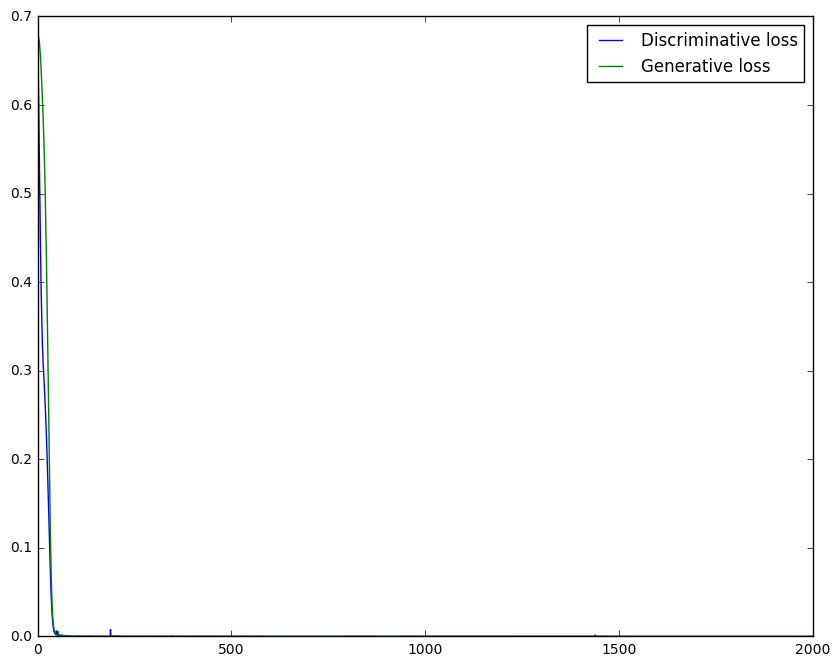

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:46<00:00, 18.70it/s]


In [457]:
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=64)


Let's check the precision of our generator for predicting the third character:

In [458]:
pred = generator.predict(XT)
pred[:,2].argmax(axis=1)

array([23,  9,  5, ..., 59,  4, 22], dtype=int64)

In [459]:
act_y = YT[:,2].argmax(axis=1)
act_y

array([ 1, 66, 64, ..., 53, 43, 68], dtype=int64)

In [460]:
sum(act_y==pred[:,2].argmax(axis=1))/len(pred)

0.00358

# Machine Translation 

Based on this greate post: <https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html> and its attached code: <https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py>


## What is sequence-to-sequence learning?

Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to Hebrew).

This can be used for machine translation or for free-form question answering (generating a natural language answer given a natural language question) -- in general, it is applicable any time you need to generate text.

In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. This requires a more advanced setup, which is what people commonly refer to when mentioning "sequence to sequence models" with no further context. Here's how it works:

A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.
Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

In [34]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://blog.keras.io/img/seq2seq/seq2seq-teacher-forcing.png")

Let's take some english-hebrew pairs from http://www.manythings.org/anki/, and train a model to translate english to hebrew.
Unicode adds some issues to confront, so it is better to convert the file to utf-8.

Let's read the file with a utf-8 encoding:

In [2]:
path='heb.txt'
text = open(path,encoding='utf-8').read()
print('corpus length:', len(text))

corpus length: 6885029


In [3]:
text[:300]

'\ufeffHi.\tהיי.\nHi.\tאהלן.\nRun!\tרוץ!\nRun!\tרוצי!\nRun!\tרוצו!\nWho?\tמי?\nWow!\tוואו!\nWow!\tואו!\nFire!\tאש!\nFire!\tשריפה!\nHelp!\tהצילו!\nJump.\tקפוץ.\nStop!\tעצור!\nGo on.\tתמשיך.\nGo on.\tתמשיכי.\nGo on.\tתמשיכו.\nHello!\tהיי.\nHello!\tאהלן.\nI ran.\tרצתי.\nI see.\tאני מבין.\nI see.\tאני מבינה.\nI see.\tאני רואה.\nI see.\tאני מבין\nI try.\tא'

We first read this file, go over each line and split it to english input text and hebrew target text. 

In [4]:
# Vectorize the data.
num_samples = 10000  # Number of samples to train on.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = text.split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 60
Max sequence length for inputs: 15
Max sequence length for outputs: 37


Let's create dictionaries from char to index, for both the english input and the hebrew output.

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

The seq2seq model requires two inputs and one output. Let's initialize zero arrays for these three, and then add the required contents

In [6]:
import numpy as np
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.


Define an input sequence and process it.

In [19]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.


In [20]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Set up the decoder, using `encoder_states` as initial state.

In [21]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

In [22]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Run training

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 36s 5ms/step - loss: 0.9449 - acc: 0.0840 - val_loss: 1.0113 - val_acc: 0.1105

In [29]:
# Save model
model.save('s2s.h5')

C:\Anaconda3\lib\site-packages\keras\engine\topology.py:2344: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [DimShuffle{0,1}.0, DimShuffle{0,1}.0]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Next: inference mode (sampling).
Here's the drill:
1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
 and a "start of sequence" token as target.
 Output will be the next target token
3. repeat with the current target token and current states

In [30]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

Reverse-lookup token index to decode sequences back to something readable.

In [31]:
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [32]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

Now watch the magic..

Here we translate the first 100 english sentences using the trained model:

In [33]:
for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: ﻿Hi.
Decoded sentence: היי.

-
Input sentence: Hi.
Decoded sentence: אהלן.

-
Input sentence: Run!
Decoded sentence: רוצי!

-
Input sentence: Run!
Decoded sentence: רוצי!

-
Input sentence: Run!
Decoded sentence: רוצי!

-
Input sentence: Who?
Decoded sentence: מי יכתל?

-
Input sentence: Wow!
Decoded sentence: וואו!

-
Input sentence: Wow!
Decoded sentence: וואו!

-
Input sentence: Fire!
Decoded sentence: שריפה!

-
Input sentence: Fire!
Decoded sentence: שריפה!

-
Input sentence: Help!
Decoded sentence: הצילו!

-
Input sentence: Jump.
Decoded sentence: קפוץ.

-
Input sentence: Stop!
Decoded sentence: עצור!

-
Input sentence: Go on.
Decoded sentence: תמשיכו.

-
Input sentence: Go on.
Decoded sentence: תמשיכו.

-
Input sentence: Go on.
Decoded sentence: תמשיכו.

-
Input sentence: Hello!
Decoded sentence: היי.

-
Input sentence: Hello!
Decoded sentence: היי.

-
Input sentence: I ran.
Decoded sentence: רצתי.

-
Input sentence: I see.
Decoded sentence: אני מבינה.

-
Input 